# Tutorial to test different filtering techniques and ML models

### Importing The Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats as stats
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
%matplotlib inline

### Rename the CSV file as per activity and load into the respective dataframe

In [2]:
file_path_sit = 'Sit_Data.csv'
file_path_walk = 'Walk_Data.csv'
file_path_run = 'Run_Data.csv'
data_sit = pd.read_csv(file_path_sit)
data_walk = pd.read_csv(file_path_walk)
data_run = pd.read_csv(file_path_run)

### Display the first few rows of the data

In [3]:
data_sit.insert(0,"Activity","Sitting")
data_walk.insert(0,"Activity","Walking")
data_run.insert(0,"Activity","Running")

### Checking if data can be extracted activity wise

In [4]:
raw_data = pd.concat([data_sit, data_walk, data_run], ignore_index=True)
raw_data[raw_data['Activity']=='Sitting']

,Activity,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,Sitting,0.015768,0.024965,0.052168,-0.029614,0.064975
1,Sitting,0.035683,0.033415,0.027016,-0.026984,0.050740
2,Sitting,0.055602,0.053850,0.027286,-0.048887,0.077681
3,Sitting,0.075521,0.066481,0.036426,-0.046459,0.088910
4,Sitting,0.095435,0.085534,0.034914,-0.032925,0.098077
...,...,...,...,...,...,...
497,Sitting,9.919370,0.030416,0.011477,-0.033339,0.046565
498,Sitting,9.939304,0.035053,-0.003066,-0.038852,0.052417
499,Sitting,9.959218,0.056140,0.011586,-0.048122,0.074844
500,Sitting,9.979134,0.061500,0.031754,-0.056474,0.089330


### Checking if the recorded is balanced

In [5]:
raw_data['Activity'].value_counts()

Sitting    502
Walking    502
Running    502
Name: Activity, dtype: int64

In [6]:
Activities = raw_data['Activity'].value_counts().index
Fs=50
Activities

Index(['Sitting', 'Walking', 'Running'], dtype='object')

### Plotting and visualising the accelerometer data

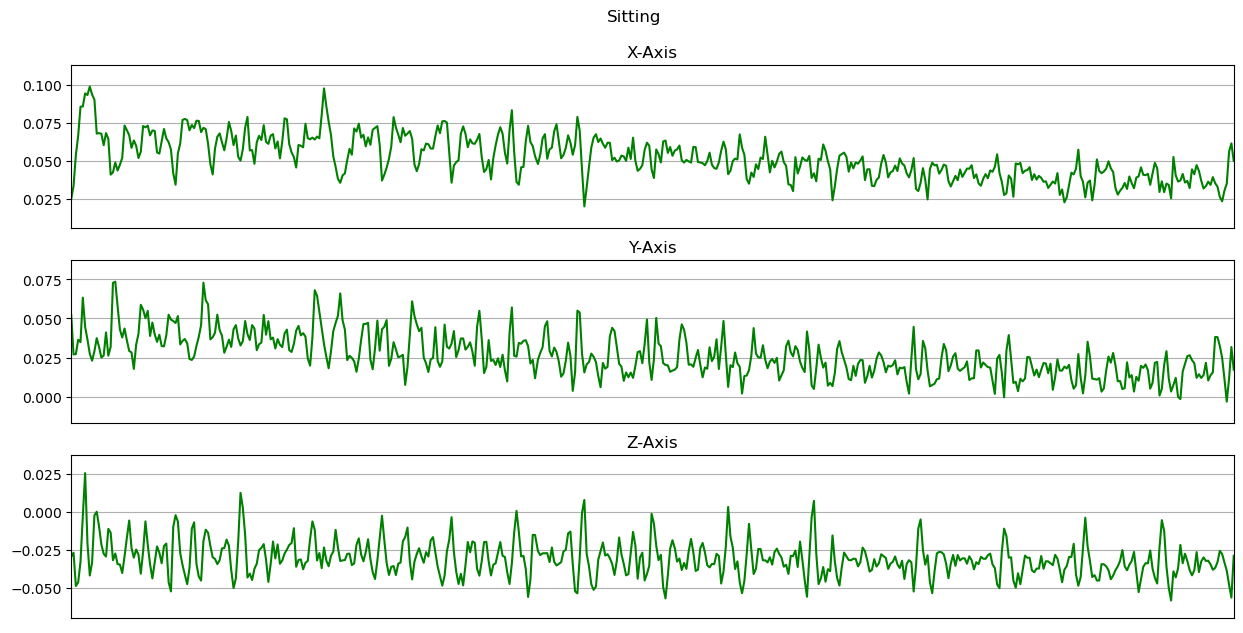

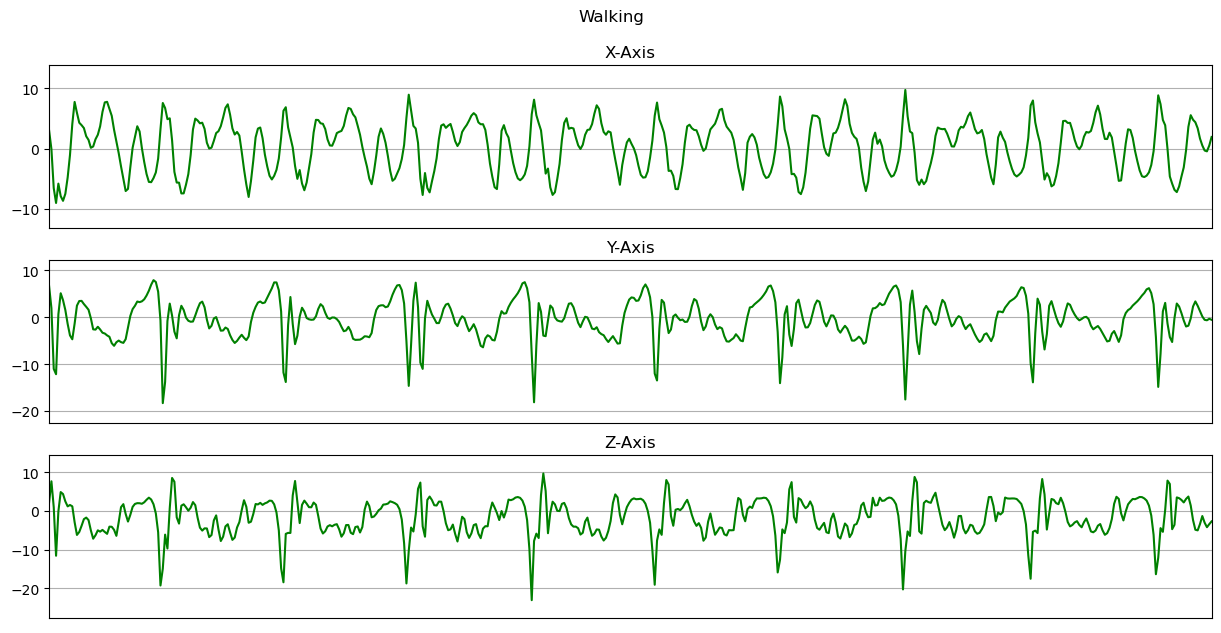

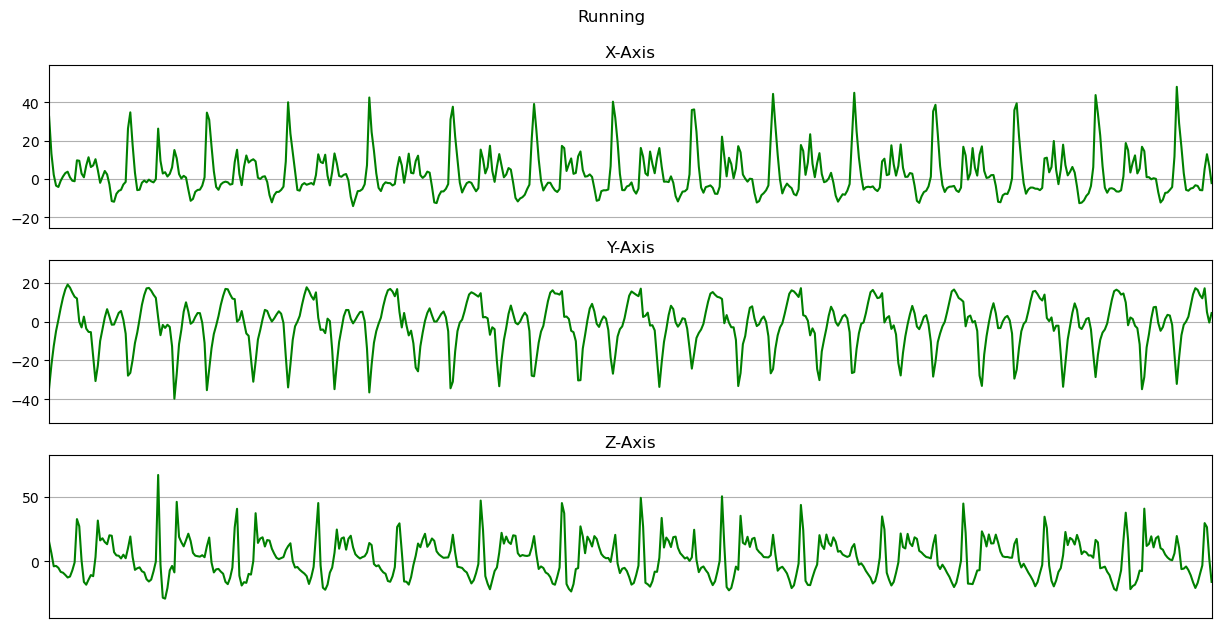

In [7]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data["Time (s)"], data["Linear Acceleration x (m/s^2)"], 'X-Axis')
    plot_axis(ax1, data["Time (s)"], data["Linear Acceleration y (m/s^2)"], 'Y-Axis')
    plot_axis(ax2, data["Time (s)"], data["Linear Acceleration z (m/s^2)"], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in Activities:
    data_for_plot = raw_data[(raw_data['Activity'] == activity)][:Fs*100]
    plot_activity(activity, data_for_plot)

### Checking if the hardware is recording data properly.

In [8]:
tsdiff= data_run['Time (s)'].diff()
tsvar=tsdiff.var()
print(tsdiff)
print(tsvar)
print(1/np.mean(tsdiff))

0           NaN
1      0.019931
2      0.019913
3      0.019916
4      0.019918
         ...   
497    0.019917
498    0.019909
499    0.019927
500    0.019915
501    0.019916
Name: Time (s), Length: 502, dtype: float64
3.345888266049333e-11
50.20823980704104


The variance in timestep is negligible and the hardware performs up to expectations

### Displaying the frequency content from an activity

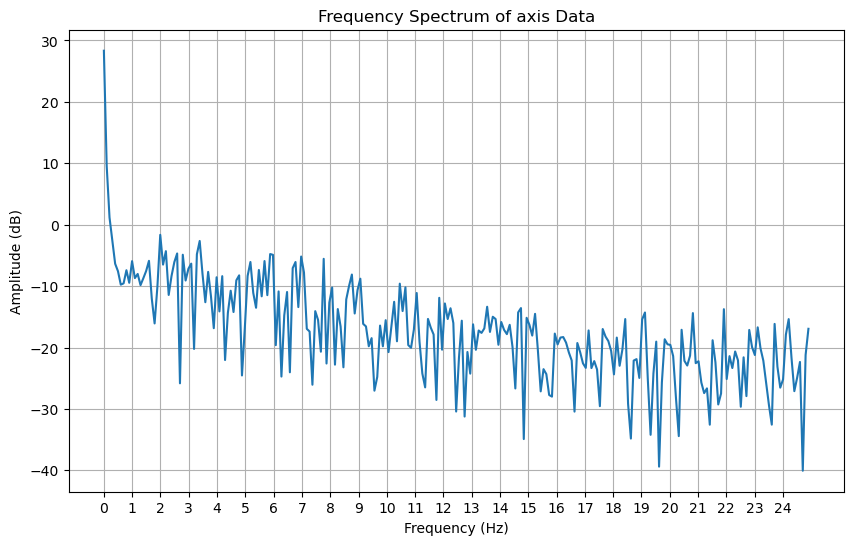

In [9]:
sampling_rate = 50
sig=raw_data[raw_data["Activity"]=="Sitting"]['Linear Acceleration x (m/s^2)'].fillna(0)
#sig2=filtered_data[filtered_data["Activity"]=="Running"]['x_sma'].fillna(0)
def plot_frequency_spectrum(column, fs, step=5):
    
    # Load the data
    data = column

    # Extract the signal data from the specified column
    signal = data.values
    
    sampling_rate = fs

    # Apply FFT
    n = len(signal)
    frequency = np.fft.fftfreq(n, d=1/sampling_rate)
    fft_values = np.fft.fft(signal)

    # Only keep the positive frequencies (real signal is symmetric)
    frequency = frequency[:n//2]
    fft_values = np.abs(fft_values[:n//2])

    # Convert FFT amplitude to decibels (dB)
    fft_values_db = 20 * np.log10(fft_values)

    # Plot the frequency spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(frequency, fft_values_db)
    plt.title(f"Frequency Spectrum of axis Data")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.grid(True)

    # Add finer x-axis ticks
    plt.xticks(np.arange(0, np.max(frequency), step=step))  # Adjust the step size as needed

    # Show the plot
    plt.show()

def plot_spectrogram(column, fs, nperseg=256, noverlap=128):

    # Load the data
    data = column

    # Extract the signal data from the specified column
    signal = data.values
    
    sampling_rate = fs

    # Generate the spectrogram
    frequencies, times, Sxx = scipy.signal.spectrogram(signal, fs, nperseg=nperseg, noverlap=noverlap)

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.title(f"Spectrogram of axis Data")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Power/Frequency (dB/Hz)")
    plt.ylim(0, np.max(frequencies))
    plt.grid(True)

    # Show the plot
    plt.show()

def plot_periodogram(column, fs):
    

    # Load the data
    data = column

    # Extract the signal data from the specified column
    signal = data.values

   
    sampling_rate = fs

    # Generate the periodogram
    frequencies, psd = scipy.signal.periodogram(signal,sampling_rate)

    # Convert PSD to decibels
    psd_db = 10 * np.log10(psd)

    # Plot the periodogram
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, psd_db)
    plt.title(f"Periodogram (PSD) of axis Data")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.grid(True)

    # Add finer x-axis ticks
    plt.xticks(np.arange(1, np.max(frequencies), step=1))  # Adjust the step size as needed

    # Show the plot
    plt.show()
    
def plot_welch(column, fs, beta=14.0, nperseg=256):
    
    # Load the data
    data = column

    # Extract the signal data from the specified column
    signal = data.values

    
    sampling_rate = fs

    # Create the Kaiser window
    window = scipy.signal.kaiser(nperseg, beta=beta)

    # Apply Welch's method with 50% overlap and Kaiser window
    frequencies, psd = scipy.signal.welch(signal, fs=sampling_rate, window=window, nperseg=nperseg, noverlap=nperseg // 2)

    # Convert PSD to decibels
    psd_db = 10 * np.log10(psd)

    # Plot the PSD
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, psd_db)
    plt.title(f"Welch PSD of axis Data with Kaiser Window and 50% Overlap")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (dB/Hz)")
    plt.grid(True)

    # Add finer x-axis ticks
    plt.xticks(np.arange(0, np.max(frequencies), step=1))  # Adjust the step size as needed

    # Show the plot
    plt.show()

plot_frequency_spectrum(sig, sampling_rate, step=1)

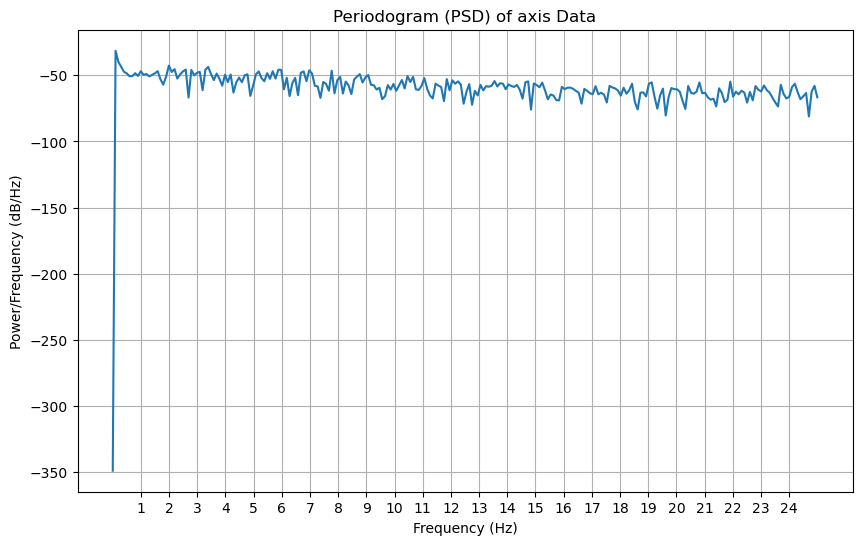

In [10]:
plot_periodogram(sig, sampling_rate)


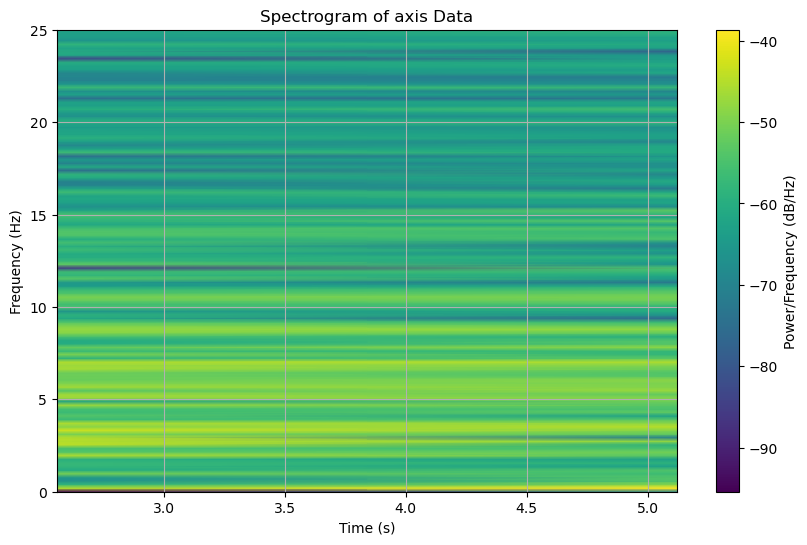

In [11]:
plot_spectrogram(sig, sampling_rate, nperseg=256, noverlap=128)

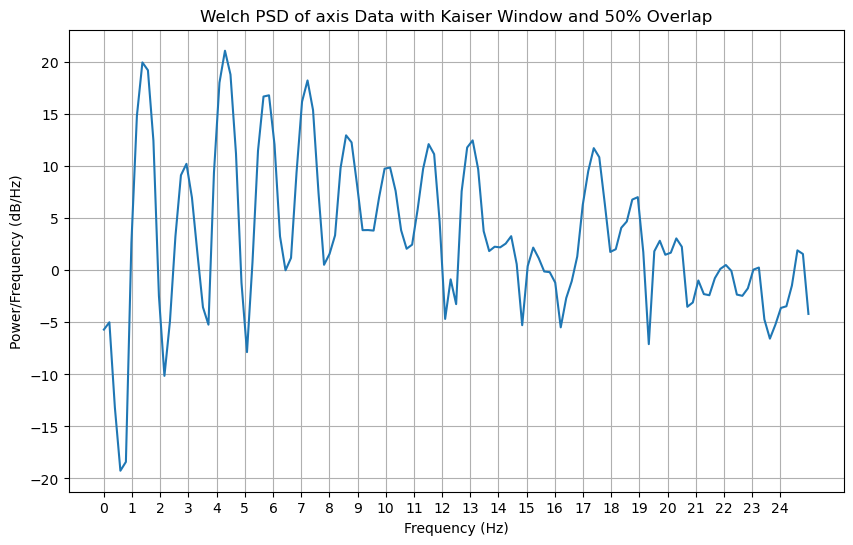

In [12]:
sig=raw_data[raw_data["Activity"]=="Running"]['Linear Acceleration z (m/s^2)'].fillna(0)
plot_welch(sig, sampling_rate, beta=14.0, nperseg=256)

#### Defining a Simple Moving Average Filter

In [13]:
def moving_average_filter(data, window_size=5):
    return data.rolling(window=window_size).mean()

#### Defining a Butterworth Filter

In [14]:
def butterworth_filter(data, cutoff=10, fs=50.0, order=30):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

### Applying the filters

In [15]:
filtered_data=raw_data
filtered_data['x_sma'] = moving_average_filter(raw_data["Linear Acceleration x (m/s^2)"])
filtered_data['y_sma'] = moving_average_filter(raw_data["Linear Acceleration y (m/s^2)"])
filtered_data['z_sma'] = moving_average_filter(raw_data["Linear Acceleration z (m/s^2)"])


filtered_data['x_butter'] = butterworth_filter(raw_data["Linear Acceleration x (m/s^2)"])
filtered_data['y_butter'] = butterworth_filter(raw_data["Linear Acceleration y (m/s^2)"])
filtered_data['z_butter'] = butterworth_filter(raw_data["Linear Acceleration z (m/s^2)"])

### Plot the filtered data

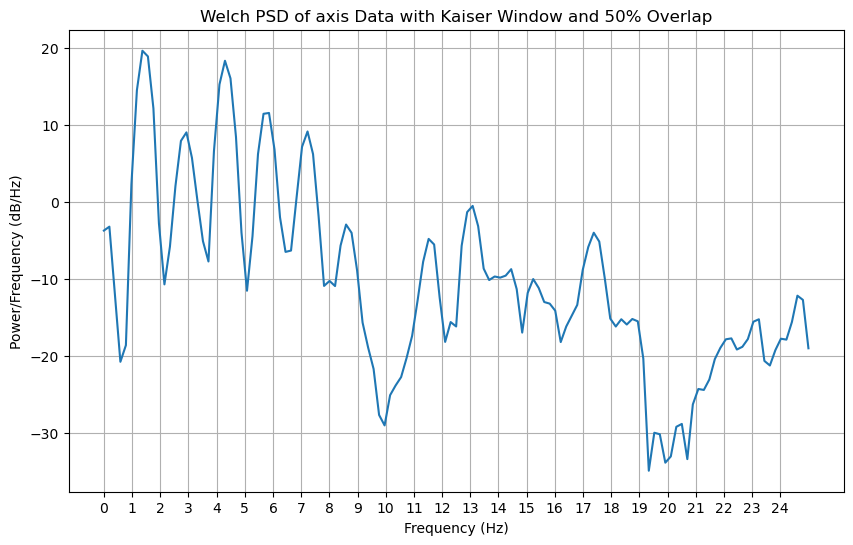

In [16]:
avsig=filtered_data[filtered_data["Activity"]=="Running"]['z_sma'].fillna(0)
plot_welch(avsig, sampling_rate, beta=14.0, nperseg=256)

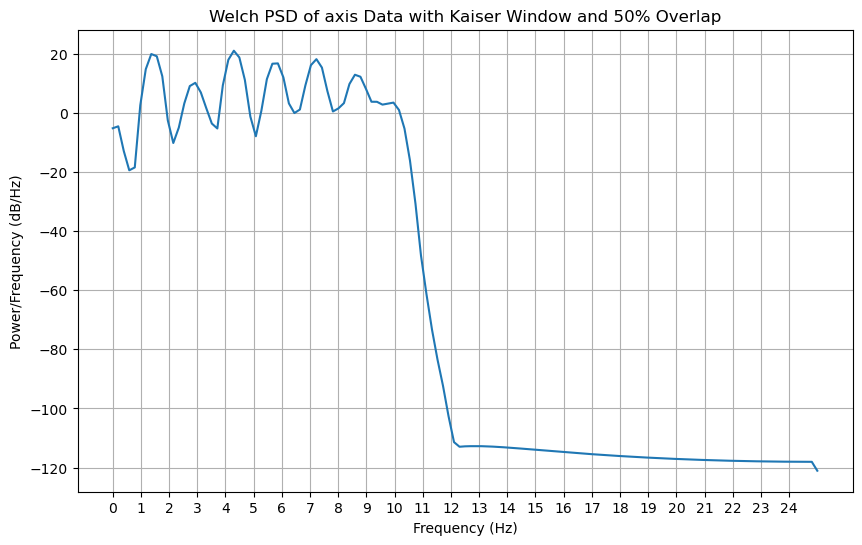

In [17]:
btsig=filtered_data[filtered_data["Activity"]=="Running"]['z_butter'].fillna(0)
plot_welch(btsig, sampling_rate, beta=14.0, nperseg=256)

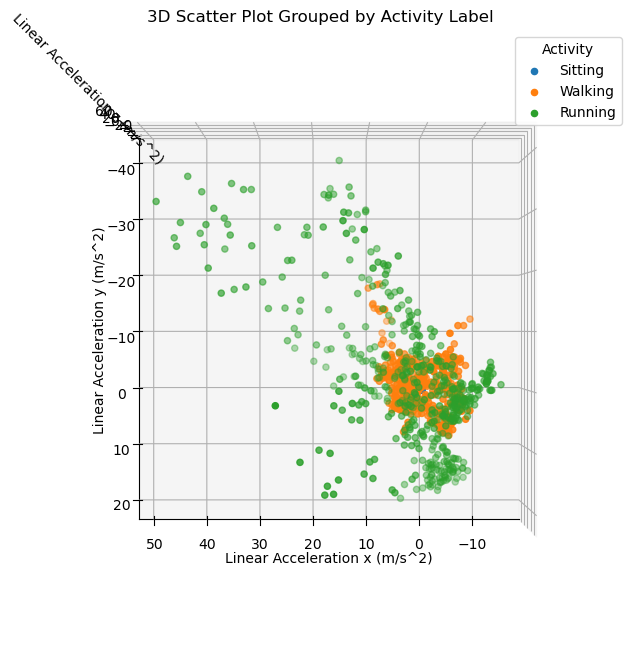

In [18]:
def plot_3d_scatter(table, x_col, y_col, z_col, label_col):
    
    # Load the data
    data = table

    # Extract the columns for X, Y, Z, and activity label
    x_data = data[x_col]
    y_data = data[y_col]
    z_data = data[z_col]
    labels = data[label_col]

    # Get the unique activity labels
    unique_labels = labels.unique()

    # Set up the 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each activity group with a different color
    for label in unique_labels:
        # Extract the data corresponding to this activity label
        idx = labels == label
        ax.scatter(x_data[idx], y_data[idx], z_data[idx], label=label)

    # Set plot labels and title
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    plt.title('3D Scatter Plot Grouped by Activity Label')
    ax.view_init(elev=90, azim=90)

    # Add a legend
    plt.legend(title=label_col)

    # Show the plot
    plt.show()

plot_3d_scatter(raw_data, "Linear Acceleration x (m/s^2)", "Linear Acceleration y (m/s^2)", "Linear Acceleration z (m/s^2)", "Activity")

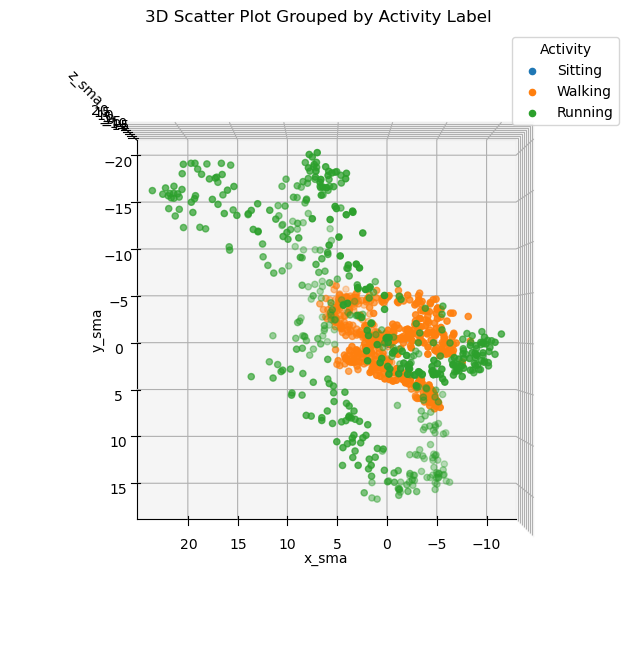

In [19]:
plot_3d_scatter(filtered_data, "x_sma", "y_sma", "z_sma", "Activity")

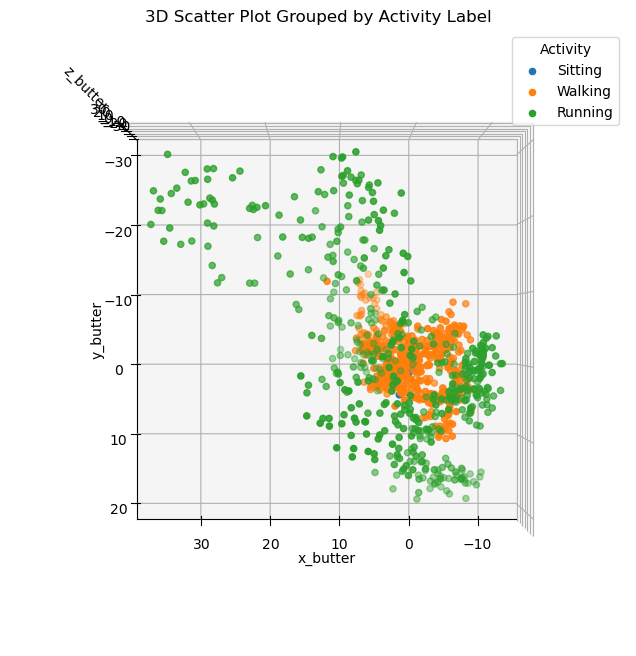

In [20]:
plot_3d_scatter(filtered_data, "x_butter", "y_butter", "z_butter", "Activity")

In [21]:
filtered_data.head(-5)

,Activity,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2),x_sma,y_sma,z_sma,x_butter,y_butter,z_butter
0,Sitting,0.015768,0.024965,0.052168,-0.029614,0.064975,NaN,NaN,NaN,0.024962,0.052178,-0.029627
1,Sitting,0.035683,0.033415,0.027016,-0.026984,0.050740,NaN,NaN,NaN,0.036719,0.030891,-0.043983
2,Sitting,0.055602,0.053850,0.027286,-0.048887,0.077681,NaN,NaN,NaN,0.051645,0.023770,-0.049528
3,Sitting,0.075521,0.066481,0.036426,-0.046459,0.088910,NaN,NaN,NaN,0.068281,0.032652,-0.040850
4,Sitting,0.095435,0.085534,0.034914,-0.032925,0.098077,0.052849,0.035562,-0.036974,0.081744,0.046609,-0.020948
...,...,...,...,...,...,...,...,...,...,...,...,...
1496,Running,9.824080,-5.011001,8.242199,-10.651524,14.370070,0.557522,0.465082,-6.523614,-3.440431,6.522960,-9.053271
1497,Running,9.843995,-4.695636,14.111450,-16.044683,21.877246,-3.705452,4.679401,-8.551317,-0.459313,11.453304,-14.478738
1498,Running,9.863921,-3.307745,17.311821,-20.493143,27.029784,-4.976821,8.459012,-11.544893,-3.437427,16.857454,-20.363618
1499,Running,9.883834,-3.655393,16.424398,-16.560478,23.608731,-4.566127,11.730247,-14.079930,-7.865109,18.839781,-20.339897


### Defining the Dependent and Independent variables

In [22]:
X = raw_data[['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']]
y = raw_data['Activity']

### Standardizing the data

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


X

array([[-0.15044778,  0.0912507 , -0.03383308],
       [-0.14925316,  0.08796446, -0.03354917],
       [-0.1463641 ,  0.08799977, -0.03591336],
       ...,
       [ 1.67471282,  0.73391711,  2.83488705],
       [ 0.79701342,  0.02625108,  0.17986692],
       [-0.46095639,  0.66825408, -1.73649276]])

### Splitting the data into Training data and Testing data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Verifying the data is as close to equally split as possible

In [25]:
y_train.value_counts()

Walking    402
Sitting    402
Running    400
Name: Activity, dtype: int64

In [26]:
X.shape, y.shape

((1506, 3), (1506,))

In [27]:
X_train.shape, X_test.shape

((1204, 3), (302, 3))

### Fitting the model and evaluating the performance

In [28]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Running       0.96      0.85      0.90       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.86      0.96      0.91       100

    accuracy                           0.94       302
   macro avg       0.94      0.94      0.94       302
weighted avg       0.94      0.94      0.94       302

Accuracy Score:
0.9370860927152318


In [29]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and get accuracy scores for each fold
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print the accuracy scores for each fold
print(f"Cross-Validation Scores: {scores}")
    
# Print the mean and standard deviation of the accuracy scores
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")

Cross-Validation Scores: [0.93708609 0.94019934 0.95016611 0.92358804 0.93023256]
Mean Accuracy: 0.936254427845372
Standard Deviation: 0.009016531983519456


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

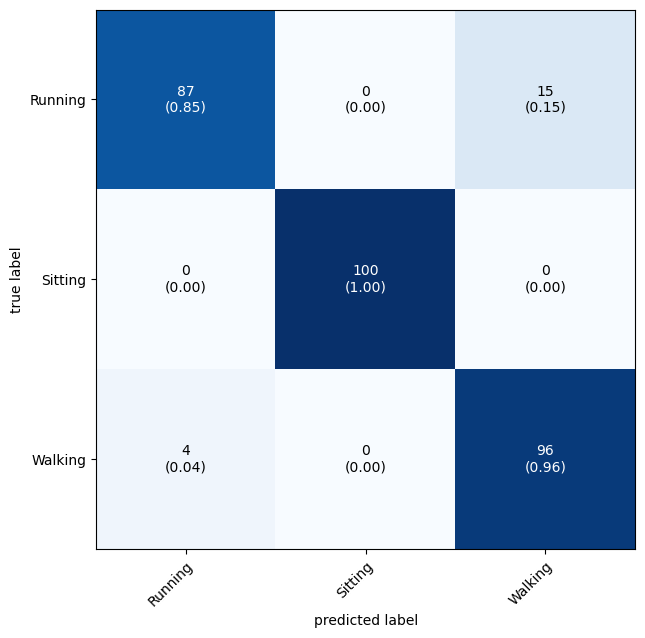

In [30]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=np.unique(y_pred), show_normed=True, figsize=(7,7))

In [31]:
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

def train_and_evaluate_model(X, y, model):
    #Standardize the values of x
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Print classification report and accuracy score
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Accuracy Score:")
    print(accuracy_score(y_test, y_pred))
    
    mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_mat=mat, class_names=np.unique(y_pred), show_normed=True, figsize=(7,7))
    
    # Perform cross-validation and get accuracy scores for each fold
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    # Print the accuracy scores for each fold
    print(f"Cross-Validation Scores: {scores}")
    
    # Print the mean and standard deviation of the accuracy scores
    print(f"Mean Accuracy: {scores.mean()}")
    print(f"Standard Deviation: {scores.std()}")


Classification Report:
              precision    recall  f1-score   support

     Running       0.98      0.96      0.97       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.96      0.98      0.97       100

    accuracy                           0.98       302
   macro avg       0.98      0.98      0.98       302
weighted avg       0.98      0.98      0.98       302

Accuracy Score:
0.9801324503311258
Cross-Validation Scores: [0.96688742 0.97342193 0.9833887  0.99003322 0.98006645]
Mean Accuracy: 0.978759543244373
Standard Deviation: 0.007995880132323326


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

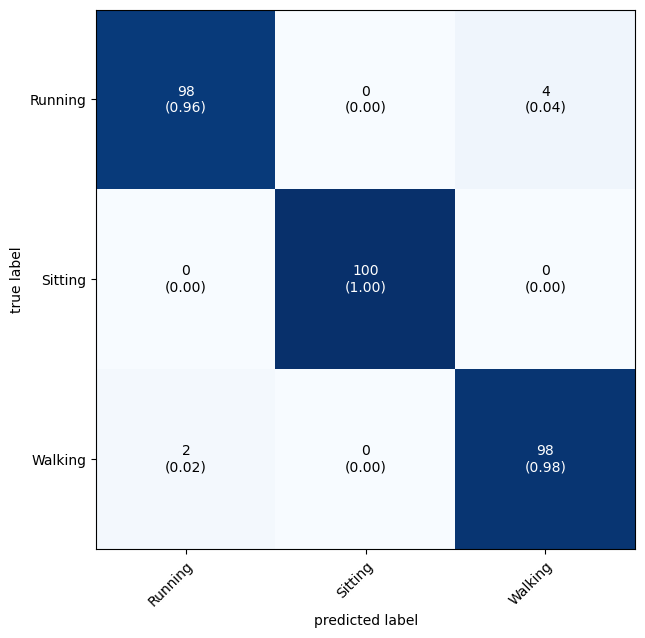

In [32]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)
X = filtered_data[['x_sma', 'y_sma', 'z_sma']].fillna(0)
y = filtered_data['Activity']

train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.96      0.95      0.96       102
     Sitting       0.98      1.00      0.99       100
     Walking       0.95      0.94      0.94       100

    accuracy                           0.96       302
   macro avg       0.96      0.96      0.96       302
weighted avg       0.96      0.96      0.96       302

Accuracy Score:
0.9635761589403974
Cross-Validation Scores: [0.91059603 0.97009967 0.97342193 0.98006645 0.96677741]
Mean Accuracy: 0.96019229499901
Standard Deviation: 0.025184577077987037


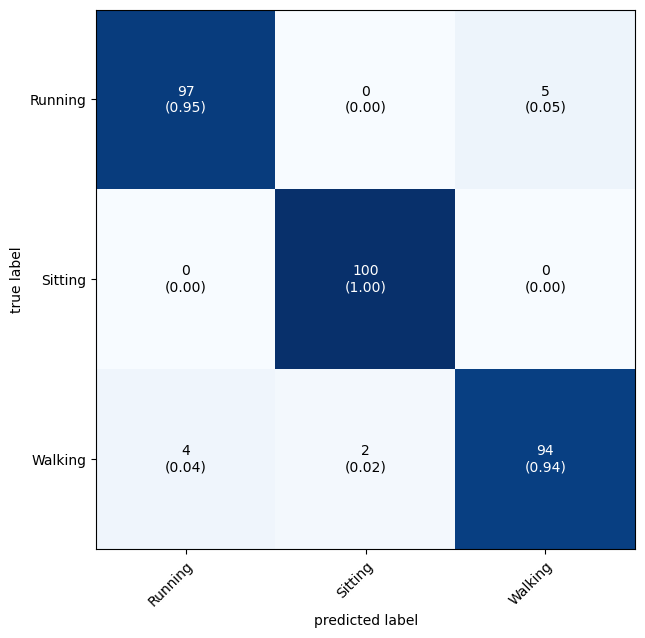

In [33]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
X = filtered_data[['x_sma', 'y_sma', 'z_sma']].fillna(0)
y = filtered_data['Activity']

train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.91      0.89      0.90       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.89      0.91      0.90       100

    accuracy                           0.93       302
   macro avg       0.93      0.93      0.93       302
weighted avg       0.93      0.93      0.93       302

Accuracy Score:
0.9337748344370861
Cross-Validation Scores: [0.92384106 0.94019934 0.94352159 0.94352159 0.95681063]
Mean Accuracy: 0.9415788431497656
Standard Deviation: 0.010545974981343732


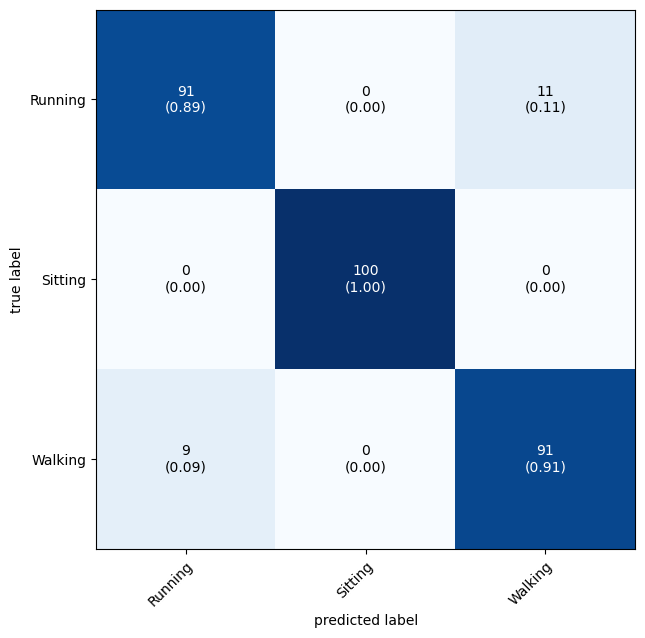

In [34]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
X = filtered_data[['x_sma', 'y_sma', 'z_sma']].fillna(0)
y = filtered_data['Activity']

train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.98      0.95      0.97       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.95      0.98      0.97       100

    accuracy                           0.98       302
   macro avg       0.98      0.98      0.98       302
weighted avg       0.98      0.98      0.98       302

Accuracy Score:
0.9768211920529801
Cross-Validation Scores: [0.9602649  0.97674419 0.98006645 0.9833887  0.9833887 ]
Mean Accuracy: 0.9767705881058723
Standard Deviation: 0.008612781355004033


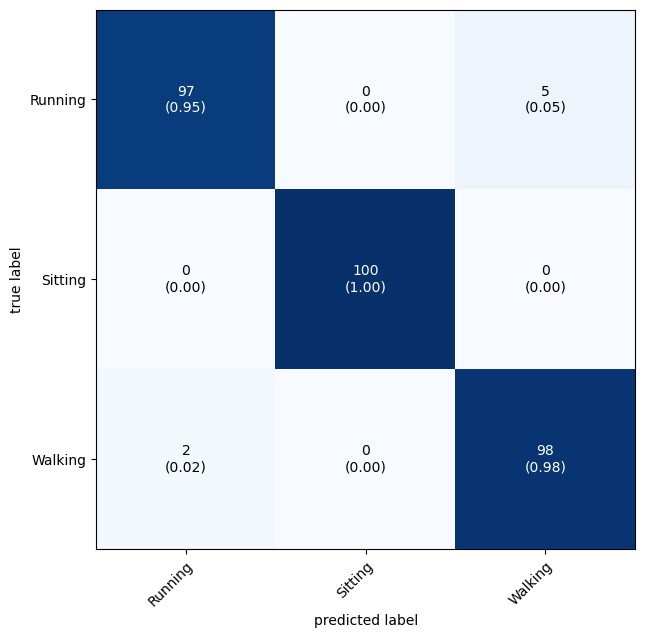

In [35]:
X = filtered_data[['x_sma', 'y_sma', 'z_sma']].fillna(0)
y = filtered_data['Activity']
model = RandomForestClassifier(n_estimators=100, random_state=42)

train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.96      0.90      0.93       102
     Sitting       1.00      0.99      0.99       100
     Walking       0.90      0.96      0.93       100

    accuracy                           0.95       302
   macro avg       0.95      0.95      0.95       302
weighted avg       0.95      0.95      0.95       302

Accuracy Score:
0.9503311258278145
Cross-Validation Scores: [0.94370861 0.97009967 0.97009967 0.97674419 0.84053156]
Mean Accuracy: 0.9402367384656003
Standard Deviation: 0.05112642962479119


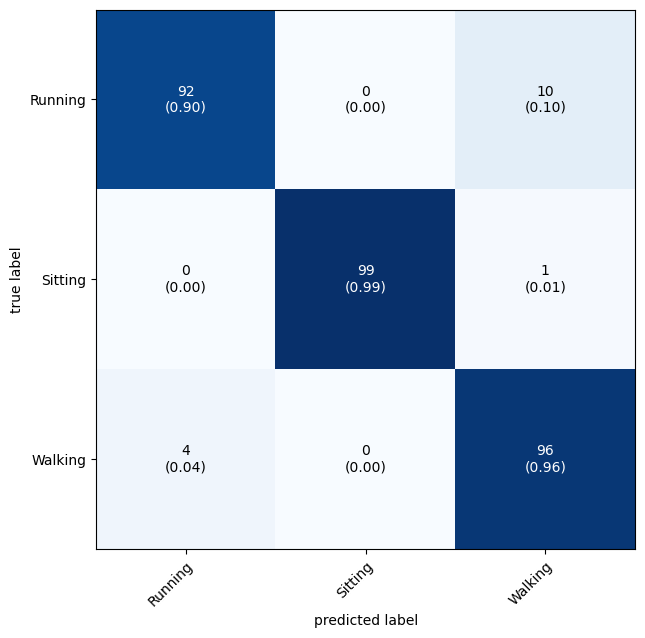

In [36]:
X = filtered_data[['x_butter', 'y_butter', 'z_butter']]
y = filtered_data['Activity']
model = RandomForestClassifier(n_estimators=100, random_state=42)

train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.96      0.85      0.90       102
     Sitting       0.99      1.00      1.00       100
     Walking       0.86      0.95      0.90       100

    accuracy                           0.93       302
   macro avg       0.94      0.93      0.93       302
weighted avg       0.94      0.93      0.93       302

Accuracy Score:
0.9337748344370861
Cross-Validation Scores: [0.93046358 0.93355482 0.9269103  0.93023256 0.91694352]
Mean Accuracy: 0.9276209544344459
Standard Deviation: 0.005738018884419699


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

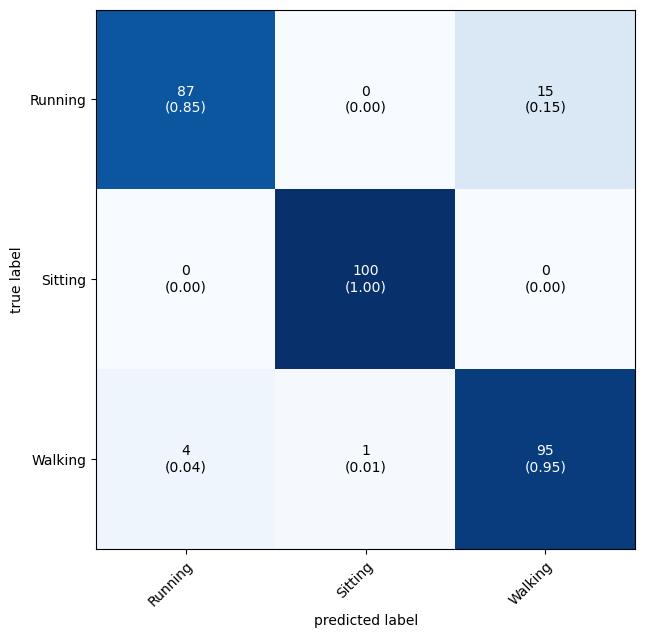

In [37]:
X = raw_data[['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']]
y = raw_data['Activity']
model = KNeighborsClassifier(n_neighbors=3)
train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.90      0.84      0.87       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.85      0.90      0.87       100

    accuracy                           0.91       302
   macro avg       0.91      0.91      0.91       302
weighted avg       0.91      0.91      0.91       302

Accuracy Score:
0.9139072847682119
Cross-Validation Scores: [0.90397351 0.89700997 0.92026578 0.910299   0.910299  ]
Mean Accuracy: 0.9083694528173197
Standard Deviation: 0.007711435470207955


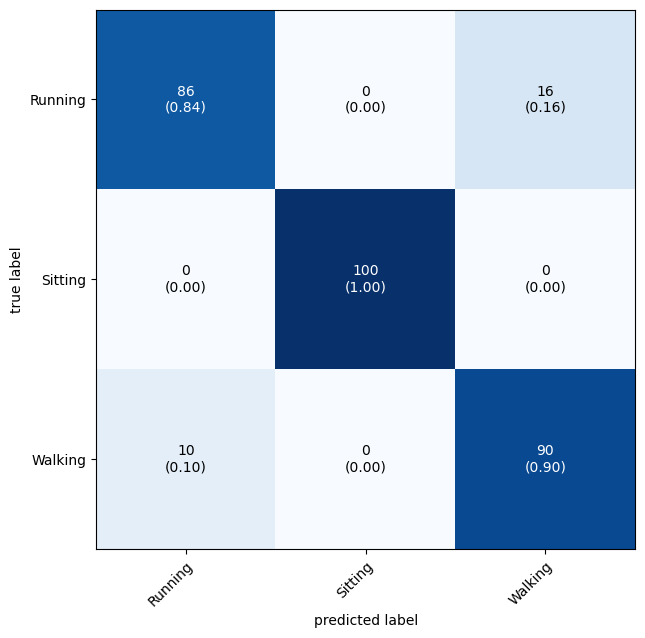

In [38]:
X = raw_data[['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']]
y = raw_data['Activity']
model = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.94      0.66      0.77       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.73      0.96      0.83       100

    accuracy                           0.87       302
   macro avg       0.89      0.87      0.87       302
weighted avg       0.89      0.87      0.87       302

Accuracy Score:
0.8708609271523179
Cross-Validation Scores: [0.88741722 0.88372093 0.90033223 0.89700997 0.90033223]
Mean Accuracy: 0.8937625134760511
Standard Deviation: 0.00689875869692571


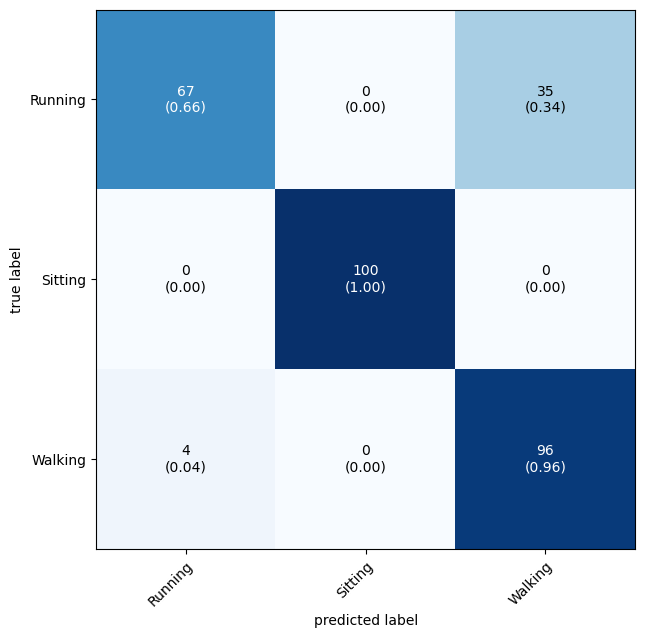

In [39]:
X = raw_data[['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)']]
y = raw_data['Activity']
model = GaussianNB()
train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.99      0.90      0.94       102
     Sitting       1.00      1.00      1.00       100
     Walking       0.91      0.99      0.95       100

    accuracy                           0.96       302
   macro avg       0.97      0.96      0.96       302
weighted avg       0.97      0.96      0.96       302

Accuracy Score:
0.9635761589403974
Cross-Validation Scores: [0.95364238 0.97009967 0.97674419 0.97674419 0.96345515]
Mean Accuracy: 0.9681371146949462
Standard Deviation: 0.008763937265963695


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

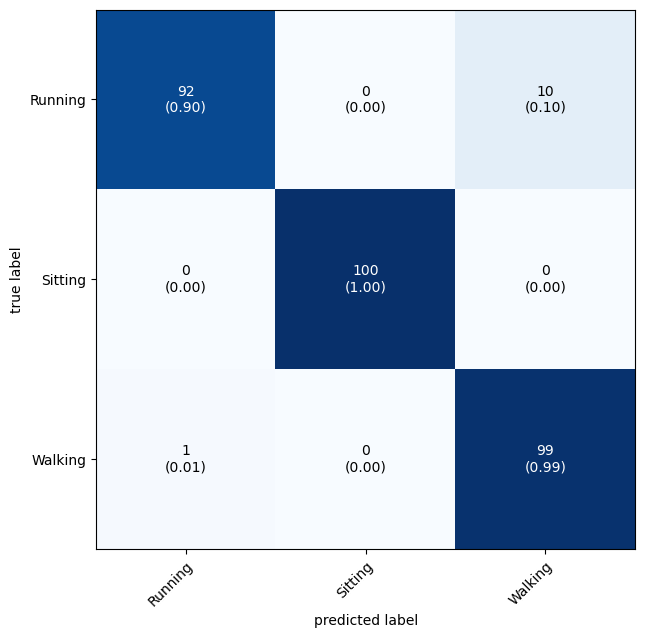

In [40]:
X = filtered_data[['x_butter', 'y_butter', 'z_butter']]
y = filtered_data['Activity']
model = KNeighborsClassifier(n_neighbors=3)
train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.91      0.89      0.90       102
     Sitting       0.99      0.99      0.99       100
     Walking       0.88      0.90      0.89       100

    accuracy                           0.93       302
   macro avg       0.93      0.93      0.93       302
weighted avg       0.93      0.93      0.93       302

Accuracy Score:
0.9271523178807947
Cross-Validation Scores: [0.91059603 0.93023256 0.9269103  0.95348837 0.78737542]
Mean Accuracy: 0.9017205342016676
Standard Deviation: 0.05878936873919733


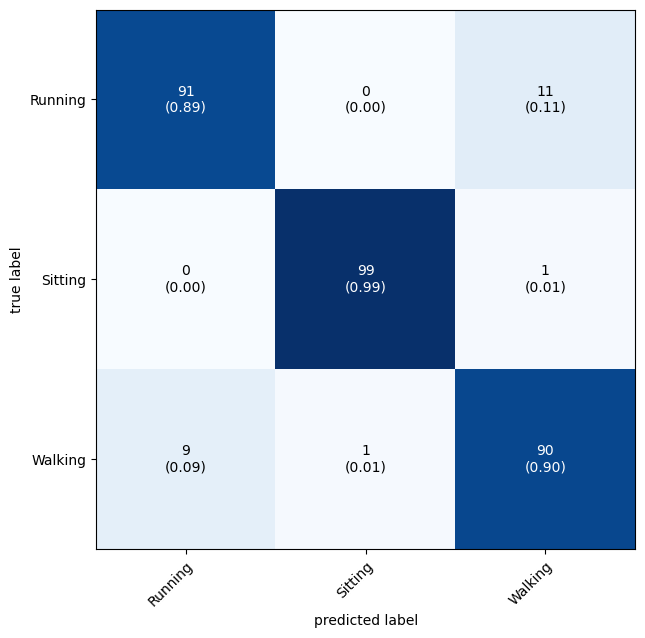

In [41]:
X = filtered_data[['x_butter', 'y_butter', 'z_butter']]
y = filtered_data['Activity']
model = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(X, y, model)

Classification Report:
              precision    recall  f1-score   support

     Running       0.92      0.78      0.85       102
     Sitting       1.00      0.98      0.99       100
     Walking       0.79      0.93      0.86       100

    accuracy                           0.90       302
   macro avg       0.90      0.90      0.90       302
weighted avg       0.90      0.90      0.90       302

Accuracy Score:
0.8973509933774835
Cross-Validation Scores: [0.91059603 0.91694352 0.91362126 0.9269103  0.7641196 ]
Mean Accuracy: 0.8864381421750898
Standard Deviation: 0.0614050885342887


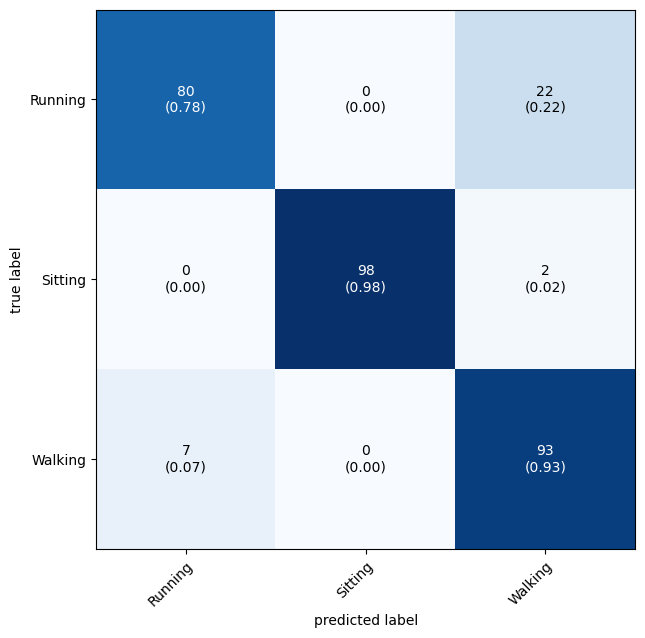

In [42]:
X = filtered_data[['x_butter', 'y_butter', 'z_butter']]
y = filtered_data['Activity']
model = GaussianNB()
train_and_evaluate_model(X, y, model)